In this file I prepare code for undersampling AF2 for actual k-space data (Rings); this will have to be transferred to matlab code.

**Strategy**

The strategy is as follows, I keep 20% of k-space data in the center of k-space (no undersampling, highest signal region).

Then I randomly delete k_z planes (except for the 20%) until I have a ~50% of data in k-space. For the next time step I do the same
but with the restriction that I take different random planes, to get a complementary pattern, etc.

In [3]:
import sys
import os

sys.path.append('../../../scripts')
sys.path.append('../../../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn

from data_preparation import *
import plotly.graph_objects as go

In [9]:
mat_data_8 = loadmat('Undersampled_P03_AF2.mat')

csi_8 = mat_data_8['csi']

US = csi_8['Data'][0,0]

#US = np.mean(Data**2, axis = -1)

#DataSpec = np.fft.fftshift(np.fft.fft(Data, axis=-1), axes=-1)    

In [10]:
US.shape

(22, 22, 21, 96, 8)

In [32]:
x,y,z,t, T = 10,10,10,5,5

US[x,y,z,t,T]

(-1497.6276+963.5033j)

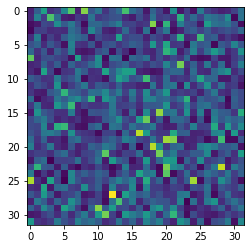

In [24]:
z, t = 5, 10

Slice = np.abs(Data[:,:,z,t])

plt.imshow(Slice)

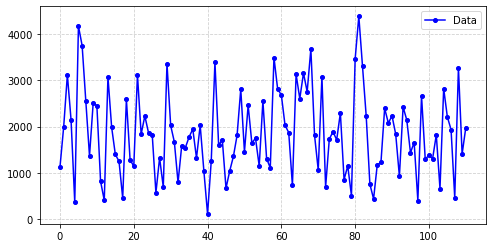

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(np.abs(DataSpec[15,15,15,:,7]), marker='o', linestyle='-', color='b', markersize=4, label="Data")

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

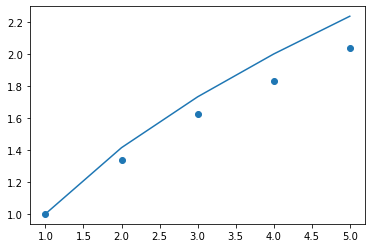

In [30]:
AF = [1, 2, 3, 4, 5]

Quot = [1, 1.34, 1.623, 1.832, 2.04]

plt.scatter(AF, Quot)
plt.plot(AF, np.sqrt(AF))

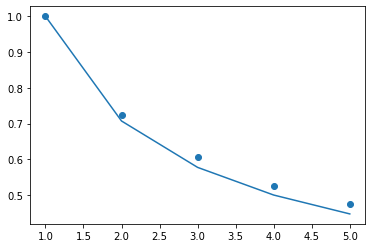

In [27]:
AF = [1, 2, 3, 4, 5]
Quot = [1, 1/1.38, 1/1.65, 1/1.9, 1/2.1]  ## this is max(undersampling) / max(fullysampled)

plt.scatter(AF, Quot)
plt.plot(AF, 1/np.sqrt(AF))

In [17]:
import numpy as np

AF   = np.array([1, 2, 3, 4, 5], dtype=float)
Quot = np.array([1, 1.38, 1.65, 1.90, 2.10], dtype=float)

# We want to fit Quot ~ AF^b => log(Quot) ~ b * log(AF).
# So b = sum( log(Quot)*log(AF) ) / sum( (log(AF))^2 ).
log_AF   = np.log(AF)
log_Quot = np.log(Quot)

b = (log_AF * log_Quot).sum() / (log_AF**2).sum()
print("Best-fit exponent b =", b)

# If you want the predicted curve for each AF:
pred = AF**b
print("Predicted Quot =", pred)


Best-fit exponent b = 0.46089323811100313
Predicted Quot = [1.         1.37639374 1.65921231 1.89445973 2.09966761]


In [ ]:
1.38

In [12]:
import sys
import os

sys.path.append('../../../scripts')
sys.path.append('../../../models')

import copy
os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import loadmat
import random

from data_preparation import *
import plotly.graph_objects as gorings
import scipy.io as sio

In [9]:
AF = 3

mata_data = loadmat(f'Undersampled_P0{3}_AF{AF}.mat')
csi_data = mata_data['csi']
Data = csi_data['Data'][0,0]

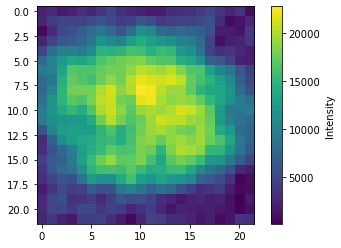

In [19]:
z, t, T = 10, 2, 0

Slice = np.abs(Data)[:,:,z,t,T]

plt.imshow(Slice)
plt.colorbar(label='Intensity')

In [13]:
Combined_Data = np.zeros((22,22,21,96,8,6))*1J
AF = 8

for i in range(0,6):
    mata_data = loadmat(f'Undersampled_P0{3+i}_AF{AF}.mat')
    csi_data = mata_data['csi']
    Data = csi_data['Data'][0,0]
    Combined_Data[...,i] = Data
    
# Define the target directory path
path = f"../../Undersampled_Data/Possoin_Real/AF_{AF}/Complementary_Masks"

# Create the directory (and any parent directories) if it doesn't exist
os.makedirs(path, exist_ok=True)    
    
np.save(f"../../Undersampled_Data/Possoin_Real/AF_{AF}/Complementary_Masks/data.npy", Combined_Data)

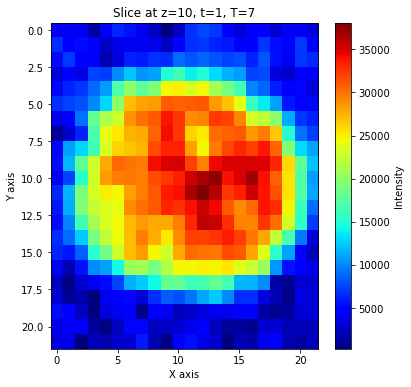

In [35]:
z, t, T = 10, 1, 7

slice_2d = np.abs(Data[:, :, z, t, T])

# Plot the slice
plt.figure(figsize=(6,6))
plt.imshow(slice_2d, cmap='jet', aspect='auto')  # Use 'jet' colormap
plt.colorbar(label="Intensity")  # Add color scale
plt.title(f"Slice at z={z}, t={t}, T={T}")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.show()

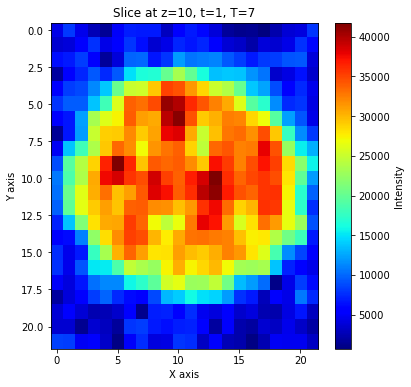

In [36]:
slice_2d = np.abs(Data_real[:, :, z, t, T])

# Plot the slice
plt.figure(figsize=(6,6))
plt.imshow(slice_2d, cmap='jet', aspect='auto')  # Use 'jet' colormap
plt.colorbar(label="Intensity")  # Add color scale
plt.title(f"Slice at z={z}, t={t}, T={T}")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.show()

In the code below, I compute exactly how much percent of k-space is sampled at which k_z position